University of Zagreb<br/>
Faculty of Electrical Engineering and Computing<br/>
Department of Electronic Systems and Information Processing

Academic year 2021/2022

## **8th laboratory exercise: Image registration**

*Digital Image Processing and Analysis* (183463)

Date: 2022-03-10

Please send any feedback (corrections, comments, suggestions etc.) regarding this document to branimir.filipovic@fer.hr.

© University of Zagreb Faculty of Electrical Engineering and Computing, 2021.

Permission is granted to make and distribute copies of this instructions provided the copyright notice and this permission notice are preserved on all copies.

# Introduction

Instructions for laboratory exercises for the course *Digital Image Processing and Analysis* are prepared in a form of a <a href="https://jupyter.org/">Jupyter</a> notebooks.

All problems in prepared notebook are intended to be completed in Python using <a href="https://colab.research.google.com">Google Colaboratory</a> platform (Colab for short).

## How to Submit Your Laboratory Report

Simply write-in your code to all empty code cells and write in your answers to the text cells with questions.

Empty code cells contain the placeholder text `# Write-in your solution` while text cells where you have to write-in someting contain a bold uppercase text **WRITE YOUR ANSWER HERE**.

Once you have completed all problems save this notebook locally in a file named DIPA_LAB_X_NAME_SURNAME.ipynb,
where X is the exercise number, and submit it via Moodle under the appropriate upload section.

Your submissions will be first automatically re-evaluated which corresponds to selecting the *Runtime/Restart and run all* command in Colab. Therefore, it is strongly suggested that you run this command yourself before submitting your notebook. Another thing to do before submission is to clear all the cell outputs by selecting *Edit/Clear all outputs*. This will reduce the size of .ipynb files for upload.

## Student Information

Before proceeding double click on this text and then fill in your name:

Name: Enio Krizman

Student ID number (JMBAG): 0069083848

## Suggested Reading

### General Reading

If you are not familiar with Python then start with a Python tutorial such as e.g. an official one available at <a href="https://docs.python.org/3/tutorial/">https://docs.python.org/3/tutorial/</a>.

Jupyter notebooks are relying on <a href="https://ipython.org/">IPython</a>, which is an interactive Python interpreter. Jupyter notebooks may be run locally or they may be conveniently executed remotely in Google Colaboratory via web browser.

Readers familiar with Matlab who have only basic knowledge of Python are strongly encouraged to read the document <a href="https://numpy.org/doc/stable/user/numpy-for-matlab-users.html">NumPy for Matlab users</a> before attempting to solve this laboratory exercise in Colab.

### Image Processing in Python

Some general image processing functions are available as a part of [`scipy.ndimage`](https://docs.scipy.org/doc/scipy/reference/ndimage.html). This basic functionality is extended by the [`scikit-image`](https://scikit-image.org/). We will also use [OpenCV](https://opencv.org/).

#Connect to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Importing Required Functions

To simplify the code in Python in this notebook we may deliberately import functions from <a href="https://www.scipy.org/">SciPy</a>, <a href="https://numpy.org/">NumPy</a> and <a href="https://matplotlib.org/">Matplotlib</a> directly into the global namespace so e.g. we can write `fft` instead of `scipy.fft.fft`.

Please keep in mind that such an approach may be tolerated for the purpose of a short laboratory exercise where risks of collisions and side effects are minimal. It is best always avoided in production code.

If you prefer to use namespaces then feel free to change the import statements to retain strict package separation, e.g. `import numpy as np`.

In [ ]:
# Import packages
import cv2
import skimage.io

# To display images in browser
from google.colab.patches import cv2_imshow

# Import some functions to the global namespace for convenience
from scipy.ndimage import *
from scipy.fft import *
from scipy.signal import * 
from scipy.stats import *
from scipy.misc import *
from skimage.registration import *
from skimage.feature import *
import skimage.util
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import *
from mpl_toolkits import mplot3d

## Image loading

We will be using images from the [USC-SIPI database](http://sipi.usc.edu/database/) and additional images available on the [DIPA class webpage](https://www.fer.unizg.hr/en/course/dipaa_b/laboratory#%23!p_rep_139398!_-187329). To load any of these images, all we have to do is copy the URL of the image and write the following two lines of code.

In [ ]:
url = "http://sipi.usc.edu/database/preview/misc/5.3.02.png"
img = skimage.io.imread(url, plugin = 'pil')

## Image representations

[Grayscale](https://en.wikipedia.org/wiki/Grayscale) images are composed exclusively of shades of gray. In a computer a 2D gray image is represented as an $M \times N$ matrix of pixel values, which merely represent light intensity. 

It takes several such matrices for colored images - one for each channel. There are several color models used for colored image representation. For instance, an [RGB](https://en.wikipedia.org/wiki/RGB_color_model) image has 3 channels (for red, green and blue color) so an $M \times N \times 3$ matrix is used.   Colored images can be converted to grayscale images, usually by performing a weighted sum of the channels. The [cv2.cvtColor()](https://docs.opencv.org/3.4/d8/d01/group__imgproc__color__conversions.html#ga397ae87e1288a81d2363b61574eb8cab) function is used to convert images from one color space to another.

These representations allow the use of common matrix operators for image processing and analysis. 

In [ ]:
url = "http://sipi.usc.edu/database/download.php?vol=misc&img=4.2.07"
img = skimage.io.imread(url, plugin = 'pil')
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) # openCV uses BGR (blue, green, red) representation
cv2_imshow(img)
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray_img)

# 8.1 Image registration
Image registration is a process consisting of an image transformation, a similarity measure (for evaluation
of the quality of the registration) and of an optimization function (for maximizing the similarity measure). 

The combination of those three elements into a registration process is given with a Fig. 8.1. 

The basic idea is this: We are registering the input image $I_S$ to the reference image $I_R$, by iteratively applying (and adapting)
the necessary transform $T$ to the image $I_S$.
Similarity measure is some measure of energy or error, and is denoted as E in this figure. Optimization
algorithm is illustrated with the feedback.

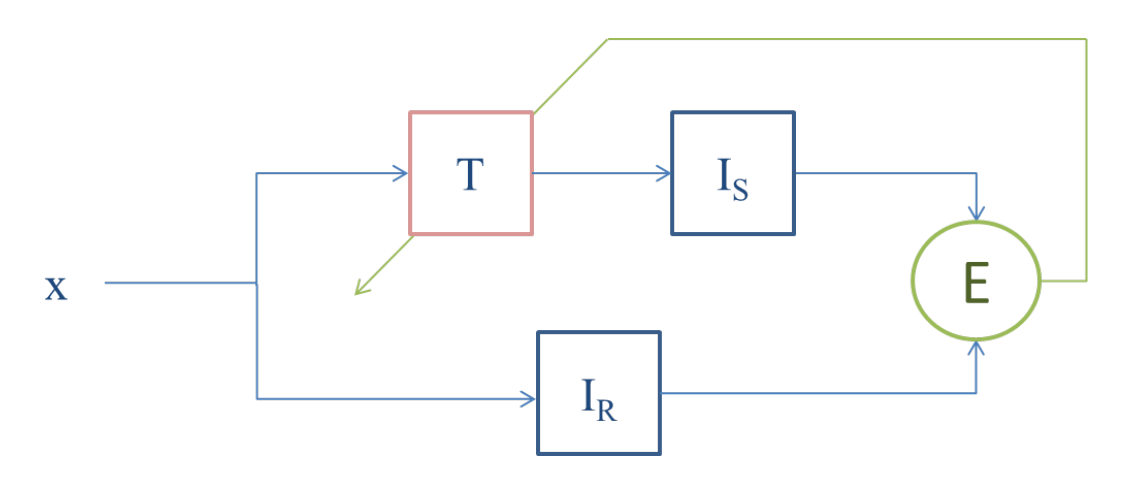

## <center>Figure 8.1: Image acquisition system. </center>

Geometrical transform is performed on the pixels’ coordinates, and not on their intensities, therefore we can
write: $$ I_T(x) = I_S(T(x)) $$
where x denotes the coordinates (x, y) (for the 2D images). 

For the sake of simplicity, we won’t be performing the optimization, but we will solve the problem by examining the complete image space with the similarity measure, and detecting its maximum. 

$$ r = \frac{\sum_{m=1}^{M}{\sum_{n=1}^{N}{(X_{mn}-\bar{X})(Y_{mn}-\bar{Y})}}}
{\sqrt{\sum_{m=1}^{M}{\sum_{n=1}^{N}{(X_{mn}-\bar{X})^2}}}
 \sqrt{\sum_{m=1}^{M}{\sum_{n=1}^{N}{(Y_{mn}-\bar{Y})^2}}}} $$

We are going to use cross-correlation $r$ as a similarity measure: where
$M$ and $N$ denote the dimensions of the overlapping area of images $X$ and $Y$, and $\bar{X}$ and $\bar{Y}$ denote mean values of $X$ and $Y$ calculated as:

$$ \bar{X} = \frac{1}{MN}\sum_{m=1}^{M}{\sum_{n=1}^{N}{X_{mn}}} $$

$$ \bar{Y} = \frac{1}{MN}\sum_{m=1}^{M}{\sum_{n=1}^{N}{Y_{mn}}} $$

In this exercise we will use registration to:

- find an object in an image
- track the object in a series of images
- determine the object’s orientation.

### **8.1.1 Problems**

1. Calculate the cross-correlation matrix $R$ for the images auto1.tiff and slika1.tiff. *Hint: Use the function [skimage.feature.match_template()](https://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.match_template)*

In [ ]:
# Write-in your solution
img = cv2.imread('/content/drive/My Drive/Images/auto1.tiff')
img1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img1, cmap='gray')
plt.show()

img = cv2.imread('/content/drive/My Drive/Images/slika1.tiff')
img2 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img2, cmap='gray')
plt.show()

R = match_template(img2, img1)

#trazenje krodinata Max
matrix = np.unravel_index(np.argmax(R), R.shape)
x_, y_ = matrix[::-1]
print("x =",x_,"y =",y_)

The cross-correlation matrix of two random vectors is a matrix containing as elements the cross-correlations of all pairs of elements of the random vectors

2. What are the coordinates $M_{ax}$ of the maximum value of the cross-correlation matrix $R$?

Kordinata maksimalne vrijednosti: (40,293)

3. Display the image $S_2$ and plot the rectangle with the dimensions of the image $S_1$ on the location of the maximum $M_{ax}$.

In [ ]:
#plot rectangle
fig, ax = plt.subplots()
ax.imshow(img2, cmap=plt.cm.gray)
hight, width = img1.shape
rect = plt.Rectangle((x_, y_), width, hight, edgecolor='g', facecolor='none')
ax.add_patch(rect)
plt.show()

4. Calculate the cross-correlation $R$ for the images auto1.tiff and

- slika2.tiff

- slika3.tiff

- slika4.tiff

Display the detections and interpret the results.

In [ ]:
img = cv2.imread('/content/drive/My Drive/Images/auto1.tiff')
img1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img1, cmap='gray')
plt.show()

# slika2
img = cv2.imread('/content/drive/My Drive/Images/slika2.tiff')
img2 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img2, cmap='gray')
plt.show()

R = match_template(img2, img1)

ij = np.unravel_index(np.argmax(R), R.shape)
x_, y_ = ij[::-1]
print("x =",x_,"y =",y_)


fig, ax = plt.subplots()
ax.imshow(img2, cmap=plt.cm.gray)
hight, width = img1.shape
rect = plt.Rectangle((x_, y_), width, hight, edgecolor='g', facecolor='none')
ax.add_patch(rect)
plt.show()

#slika3
img = cv2.imread('/content/drive/My Drive/Images/slika3.tiff')
img3 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img3, cmap='gray')
plt.show()

R = match_template(img3, img1)

ij = np.unravel_index(np.argmax(R), R.shape)
x_, y_ = ij[::-1]
print("x =",x_,"y =",y_)


fig, ax = plt.subplots()
ax.imshow(img3, cmap=plt.cm.gray)
hight, width = img1.shape
rect = plt.Rectangle((x_, y_), width, hight, edgecolor='g', facecolor='none')
ax.add_patch(rect)
plt.show()

#slika4
img = cv2.imread('/content/drive/My Drive/Images/slika4.tiff')
img4 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img4, cmap='gray')
plt.show()

R = match_template(img4, img1)

ij = np.unravel_index(np.argmax(R), R.shape)
x_, y_ = ij[::-1]
print("x =",x_,"y =",y_)


fig, ax = plt.subplots()
ax.imshow(img4, cmap=plt.cm.gray)
hight, width = img1.shape
rect = plt.Rectangle((x_, y_), width, hight, edgecolor='g', facecolor='none')
ax.add_patch(rect)
plt.show()

Pomoću ranije navedenog postupka uspješno se prati položaj auta na slici.

5. Write a function that calculates the cross-correlation of two images where one of the images is only rotated
for a single angle $\alpha$. Use the functions [skimage.feature.match_template()](https://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.match_template) and [scipy.misc.imrotate()](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.misc.imrotate.html). The inputs should be $S_1$,
$S_2$, and $\alpha$; the output should be the cross-correlation matrix $R$ for the given angle.

In [ ]:
#rotate original image for angle
def rotation(img1, imag2, angle ):
  img1 = skimage.transform.rotate(img2, angle)
  result =match_template(img1, img2)
  return result

6. Calculate the cross-correlation matrix $R$ for the images auto1.tiff and auto2.tiff for all of the angles in the
$\alpha = range(0, 360, 1)$. Plot the curve that shows the cross-correlation for all of these angles. Which
$\alpha$ corresponds to the maximal cross-correlation? Why?

In [ ]:
# Write-in your solution
img = cv2.imread('/content/drive/My Drive/Images/auto1.tiff')
img1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img1, cmap='gray')
plt.show()

img = cv2.imread('/content/drive/My Drive/Images/auto2.tiff')
img2 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img2, cmap='gray')
plt.show()

R= []
#put all solutions in array
for angle in range(361):
  R.append(rotation(img1, img2, angle))
#get scalar values for plot
R = [np.asscalar(r) for r in R]
plt.figure()
plt.plot(range(361), R)
plt.show()

Najveća korelacija je na vrijednosti 0(360) jer je su u toj poziciji slike jednake te što je veći zakret od početnog položaja, manja je korelacija.

## 8.2 Optical flow

Optical flow is an independent estimate of motion at each pixel. This can be expressed with the following formula:

$$ OF(\{u_i\}) = \sum_i{[I_1(x_i + u_i) - I_0(x_i)]^2}$$

for some motion $\{u_i\}$ consisting of motion vectors $u_i$ defined for each pixel.

As one can see, the number of variables is larger than the number of measurements and therefore the problem in question is underconstrained. 

### **8.2.1 Problems**

1. Write a function that calculates the optical flow between a grayscale image $S$ and the same image $S$ shifted by vector $D = (dx, dy)$ (Pad and crop the image as necessary). *Hint: Use the function [skimage.registration.optical_flow_tvl1()](https://scikit-image.org/docs/dev/api/skimage.registration.html?highlight=skimage%20registration#skimage.registration.optical_flow_tvl1)*

In [ ]:
def shift_image(X, dx, dy):
    X = np.roll(X, dy, axis=0)
    X = np.roll(X, dx, axis=1)
    if dy>0:
        X[:dy, :] = 0
    elif dy<0:
        X[dy:, :] = 0
    if dx>0:
        X[:, :dx] = 0
    elif dx<0:
        X[:, dx:] = 0
    return X



def optical_flow(img_1,vectorx, vectory):
  img_2=shift_image(img_1, vectorx, vectory)

  flow = optical_flow_tvl1(img_1, img_2)
  v = flow[0]
  u=flow[1]

  nr = img_1.shape[0]
  nc = img_1.shape[1]


  [b,g,r]=np.dsplit(img_1,img_1.shape[-1])

  row_coords, col_coords = np.meshgrid(np.arange(nr), np.arange(nc),
                                     indexing='ij')

  image1_warp = warp(b, np.array([row_coords + v, col_coords + u]),
                   mode='edge') 


  return image1_warp

2. Use the function above to visualize the optical flow of auto1.tiff. Use the following shifts: (5, 0), (10, 0), (20, 0). Display the results and comment on them.

In [ ]:
# Write-in your solution
img1 = cv2.imread('/content/drive/My Drive/Images/auto1.tiff')
img = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
plt.imshow(img1, cmap='gray')
plt.show()

print(img1.shape)

img1= optical_flow(img1,5,5)
plt.imshow(img1, cmap='gray')
plt.show()

img2=optical_flow(img,(10,0))
plt.imshow(img2, cmap='gray')
plt.show()

img3=optical_flow(img,(20,0))
plt.imshow(img3, cmap='gray')
plt.show()

**WRITE YOUR ANSWERS HERE**